In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import sys

sys.path.append('../data')

from dataloader import *
from sklearn.metrics import accuracy_score

%load_ext autoreload
%autoreload 2

In [3]:
# Config variables
batch_size = 32
val_size = 0.1
test_size = 0.1

num_heads = 3
num_layers = 2
learning_rate = 0.0001

In [4]:
# Load the data into DataLoader
train_loader, val_loader, test_loader = get_dataloader(batch_size, val_size, test_size)

The number of negative values in target_HF column is: 12479
The number of positive values in target_HF column is: 7917


In [5]:
class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks=2, dropout_prob=0.1, hidden_size = 64):
        super(ResNet, self).__init__()
        self.linear = nn.Linear(in_features[0]*in_features[1], hidden_size)
        #self.blocks = nn.ModuleList([ResNetBlock(hidden_size, dropout_prob=dropout_prob) for _ in range(num_blocks)])
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.prediction = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # reshape x to (batch_size, 46 * 3)
        x = self.linear(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.prediction(x)
        return x.squeeze()


In [6]:
# Define the loss function
loss_fn = nn.BCELoss()

# Define the model
model = ResNet(in_features=(46,3), num_blocks=2, dropout_prob=0.1, hidden_size = 64)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train the model
num_epochs = 100

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Training loop
    train_loss = 0
    train_preds = []
    train_labels = []
    for batch in train_loader:
        batch_x = batch['patient']
        batch_y = batch['label']
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y.flatten())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.shape[0]
        preds = outputs > 0.5
        train_preds.extend(preds.tolist())
        train_labels.extend(batch_y.tolist())
    
    # Validation loop
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch_x = batch['patient']
            batch_y = batch['label']
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y.flatten())
            val_loss += loss.item() * batch_x.shape[0]
            preds = outputs > 0.5
            val_preds.extend(preds.tolist())
            val_labels.extend(batch_y.tolist())
    val_acc = accuracy_score(val_labels, val_preds)
    train_acc = accuracy_score(train_labels, train_preds)
    
    # Append losses and accuracies to lists for plotting
    train_loss /= len(train_loader)*batch_size
    val_loss /= len(val_loader)*batch_size
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Print epoch information
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/100, Train Loss: 0.6274, Val Loss: 0.5783, Train Acc: 0.6410, Val Acc: 0.7039
Epoch 2/100, Train Loss: 0.5707, Val Loss: 0.5704, Train Acc: 0.7041, Val Acc: 0.7034
Epoch 3/100, Train Loss: 0.5645, Val Loss: 0.5633, Train Acc: 0.7082, Val Acc: 0.7196
Epoch 4/100, Train Loss: 0.5668, Val Loss: 0.5653, Train Acc: 0.7054, Val Acc: 0.7093
Epoch 5/100, Train Loss: 0.5623, Val Loss: 0.5565, Train Acc: 0.7092, Val Acc: 0.7206
Epoch 6/100, Train Loss: 0.5588, Val Loss: 0.5561, Train Acc: 0.7139, Val Acc: 0.7245
Epoch 7/100, Train Loss: 0.5578, Val Loss: 0.5560, Train Acc: 0.7111, Val Acc: 0.7245
Epoch 8/100, Train Loss: 0.5547, Val Loss: 0.5523, Train Acc: 0.7125, Val Acc: 0.7255
Epoch 9/100, Train Loss: 0.5568, Val Loss: 0.5503, Train Acc: 0.7143, Val Acc: 0.7304
Epoch 10/100, Train Loss: 0.5534, Val Loss: 0.5495, Train Acc: 0.7147, Val Acc: 0.7255
Epoch 11/100, Train Loss: 0.5518, Val Loss: 0.5515, Train Acc: 0.7176, Val Acc: 0.7240
Epoch 12/100, Train Loss: 0.5519, Val Loss: 0.5506, 

Epoch 96/100, Train Loss: 0.5354, Val Loss: 0.5484, Train Acc: 0.7309, Val Acc: 0.7338
Epoch 97/100, Train Loss: 0.5337, Val Loss: 0.5485, Train Acc: 0.7298, Val Acc: 0.7294
Epoch 98/100, Train Loss: 0.5352, Val Loss: 0.5459, Train Acc: 0.7297, Val Acc: 0.7407
Epoch 99/100, Train Loss: 0.5354, Val Loss: 0.5524, Train Acc: 0.7292, Val Acc: 0.7265
Epoch 100/100, Train Loss: 0.5334, Val Loss: 0.5468, Train Acc: 0.7321, Val Acc: 0.7333


In [8]:
# Set the model to evaluation mode
model.eval()

# Test loop
test_loss = 0
test_preds = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        batch_x = batch['patient']
        batch_y = batch['label']
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y.flatten())
        test_loss += loss.item() * batch_x.shape[0]
        preds = outputs > 0.5 #torch.argmax(outputs, dim=1)
        test_preds.extend(preds.tolist())
        test_labels.extend(batch_y.tolist())
test_acc = accuracy_score(test_labels, test_preds)

# Print test results
test_loss /= len(test_loader)*batch_size
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.5358, Test Acc: 0.7294


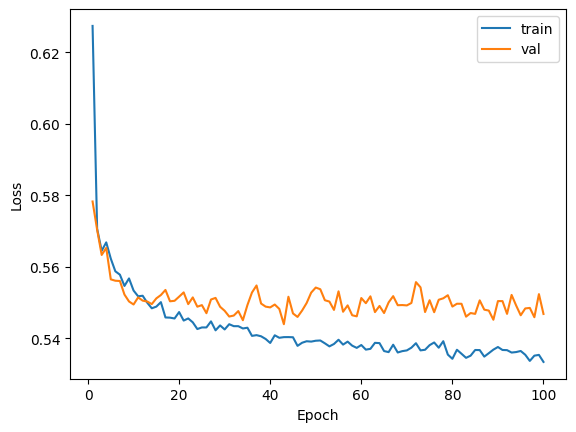

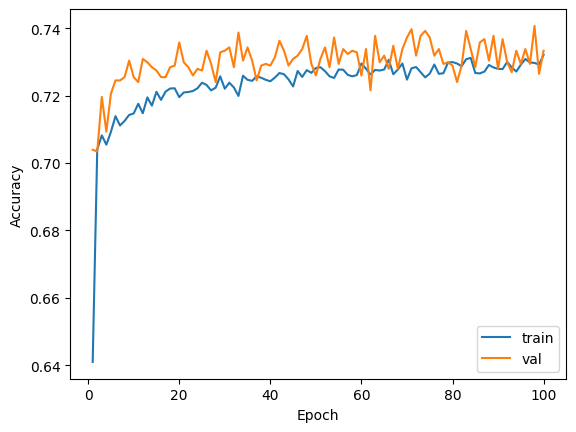

In [9]:
import matplotlib.pyplot as plt

# Plot the losses and accuracies
epochs = np.arange(1, num_epochs+1)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accs, label='train')
plt.plot(epochs, val_accs, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()